In [12]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
from scipy.linalg import eigvals
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from numpy.linalg import matrix_power
from scipy.stats import linregress
from math import acos

In [13]:
#N=10 #Dimension of the Hilbert Space
#S=5
dim=10
N=dim
N_av=100 #Number of times to average
A=1 #Probability distribution will be P~exp(-A x^2)
sigma=np.sqrt(A/2)
t_max=1
n_points_t=50
t_arr=np.linspace(0, t_max, n_points_t)

basis = np.identity(dim)
i=complex(0,1)
β=5

In [14]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
#@numba.jit(complex128[:,:](complex128[:], complex128[:]), nopython=True, fastmath=True, parallel=False)
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz
"""Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)"""

"Sx=np.zeros((dim, dim))\nSy=np.zeros((dim, dim), dtype=complex)\nSx=Compute_Sx(basis, S)\nSy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones\nSz=Compute_Sz(S)"

In [15]:
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N)
    H=(auxH+auxH.T)
    return H
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128)
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma)
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2)
            b=np.random.normal(0,sigma)/np.sqrt(2)
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    return H

In [16]:
def fid(r, r_t):
    return (np.abs(np.trace(sqrtm(sqrtm(r)@r_t@sqrtm(r)))))**2

In [17]:
def RMTQuench(t, dim, N_av, β, Nt):
    dt=t[1]-t[0]
    H0_arr=np.zeros((dim, dim, N_av), dtype=complex)
    Ht_arr=np.zeros((dim, dim, N_av), dtype=complex)
    rho0_arr=np.zeros((dim, dim, N_av, Nt), dtype=complex)
    rhot_arr=np.zeros((dim, dim, N_av, N_av, Nt), dtype=complex)
    U_arr=np.zeros((dim, dim, N_av), dtype=complex)
    invU_arr=np.zeros((dim, dim, N_av), dtype=complex)
    fidt_arr=np.zeros((N_av, N_av, Nt))
    avE=np.zeros((N_av, N_av))
    avE2=np.zeros((N_av, N_av))
    E0_arr=np.zeros(N_av)
    Z_arr=np.zeros(N_av)
    for k in range(N_av):
        H0=RMT_GUE(dim, sigma)
        H0_arr[:,:,k]=H0
        eigval, evec=eig(H0)
        Z=np.sum(np.exp(-β*eigval))
        Z_arr[k]=Z
        #E0_aux[k]=np.min(eigval)
        for j in range(dim):
            for l in range(Nt):
                rho0_arr[:,:, k, l]+=np.exp(-(β+i*t[l])*eigval[j])*ketbra(evec[j], evec[j])/Z
    for j in range(N_av):
        Ht=RMT_GUE(dim, sigma)
        Ht_arr[:,:,j]=Ht
        auxE=np.linalg.eigvals(Ht)
        E0_arr[j]=np.min(auxE)
        U_arr[:,:,j]=expm(i*Ht*dt)
        invU_arr[:,:,j]=expm(-i*Ht*dt)
        #Uaux=expm(-i*Ht*t[-1])
        #invUaux=expm(i*Ht*t[-1])
        #Ht_arr[:,:,j]=invU_arr[:,:,j]@Ht@U_arr[:,:,j]
    for j in range(N_av):
        for k in range(N_av):
            rhot_arr[:,:,k,j,0]=rho0_arr[:,:,k, 0]
            fidt_arr[k,j,0]=1
            for l in range(1,Nt):
                rhot_arr[:,:,k, j, l]=invU_arr[:,:,j]@rhot_arr[:,:,k,j, l-1]@U_arr[:,:,j]
                fidt_arr[k,j,l]=fid(rho0_arr[:,:,k, 0], rhot_arr[:,:,k, j, l])
            avE[j,k]=Z_arr[k]*np.trace((Ht_arr[:,:,j]+H0_arr[:,:,k])@rho0_arr[:,:,k, 0])
            avE2[j,k]=Z_arr[k]*np.trace((Ht_arr[:,:,j]+H0_arr[:,:,k])@(Ht_arr[:,:,j]+H0_arr[:,:,k])@rho0_arr[:,:,k, 0])
            #avE2[j,k]=np.trace((Ht_arr[:,:,j]@Ht_arr[:,:,j]+H0_arr[:,:,k]@H0_arr[:,:,k])@rho0_arr[:,:,k, 0])
    avZ=np.average(Z_arr)
    E=np.average(avE)/avZ
    E2=np.average(avE2)/avZ
    E0=np.average(E0_arr)
    E_E0=E-E0
    deltaE=np.sqrt(E2-E**2)
    fidt=np.zeros(Nt)
    for l in range(Nt):
        fidt[l]=np.average(fidt_arr[:,:,l])
    return fidt, E_E0, deltaE

In [18]:
fidt, E_E0, deltaE=RMTQuench(t_arr, dim, N_av, β, len(t_arr))

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


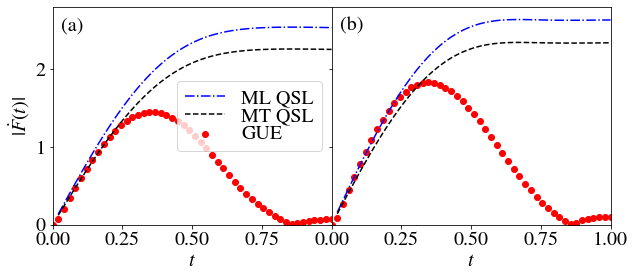

In [33]:
#print(fid_t)
#print(fid_t_aux)
if np.any(np.max(np.imag(fidt))>1e-8):
    print('Complex Warning')
fid_t=np.real(fidt)
if np.any(fid_t>1):
    print(np.max(fid_t))
    fid_t[np.argmax(fid_t)]=1
dfid_dt=np.zeros(n_points_t)
dt=t_arr[1]-t_arr[0]
for k in range(1,n_points_t):
    dfid_dt[k]=(fid_t[k]-fid_t[k-1])/dt
"""t_plot=np.zeros(n_points_t-1)
for k in range(n_points_t-1):
    t_plot[k]=t_arr[k+1]"""
BuresAng=np.arccos(np.sqrt(fid_t))
#BuresAng=np.pi/2
#print(BuresAng)
t_QSL=BuresAng*np.max([1/deltaE, 1/E_E0])
v_gamma=(1-fid_t)/t_QSL
#v_gamma[0]=0
#v_gamma2=(np.sin(BuresAng))**2/t_QSL
fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, figsize=[10, 4])
plt.subplots_adjust(wspace=0)
ax1.plot(t_arr, ML_b1, color='blue', ls="-.",label="ML QSL")
ax1.plot(t_arr, MT_b1, color='black', ls="--",label="MT QSL")
ax1.scatter(t_arr, Fdot_b1, label="GUE", color='red')
ax2.plot(t_arr, (1-fid_t)/(BuresAng/E_E0), color='blue', ls="-.",label="ML QSL")
ax2.plot(t_arr, (1-fid_t)/(BuresAng/deltaE), color='black', ls="--",label="MT QSL")
ax2.scatter(t_arr, np.abs(dfid_dt), label="GUE", color='red')
#plt.plot(t_arr, fid_t)
#plt.errorbar(t_arr, BuresAng, yerr=sigma_fid, color='red', linestyle='None', capsize=2)
#plt.scatter(t_arr, np.real(trS))
#plt.xlim(0, 0.5)
ax1.set_ylim(0,3)
ax1.set_ylabel(r"$|\dot{F}(t)|$")
ax1.set_xlabel("$t$")
ax1.set_xlim(0, 1)
ax2.set_xlim(0,1)
ax1.set_ylim(0, 2.8)
ax1.legend(labelspacing=0)
ax1.set_xticks([0,0.25, 0.5, 0.75])
ax1.text(0.03, 2.5, "(a)")
ax2.text(0.03, 2.5, "(b)")
ax2.set_xlabel("$t$")
#plt.yscale('log')
#plt.ylim(0, 0.6)
plt.show()

In [20]:
"""plt.figure()
plt.plot(t_arr, fid_t)
#plt.yscale('log')
#plt.xscale('log')
plt.show()"""

"plt.figure()\nplt.plot(t_arr, fid_t)\n#plt.yscale('log')\n#plt.xscale('log')\nplt.show()"

In [21]:
"""ML_b1=(1-fid_t)/(BuresAng/E_E0)
MT_b1=(1-fid_t)/(BuresAng/deltaE)
Fdot_b1=np.abs(dfid_dt)"""

'ML_b1=(1-fid_t)/(BuresAng/E_E0)\nMT_b1=(1-fid_t)/(BuresAng/deltaE)\nFdot_b1=np.abs(dfid_dt)'